<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0IT0EN1221-2023-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Singular-Value Decomposition (SVD)**

Estimated time needed: **45** minutes

A self-driving car company just hired you as a computer vision engineer. The company is developing video inpainting algorithms, and your first mission is to remove all objects other than the street from several security videos. In this project you will use Singular-Value Decomposition (SVD) to help test their vision system.

This tutorial will help you understand the basic concepts of SVD, then guide you through implementing these techniques to handle videos. You will practice with the examples from  <a href="www.svcl.ucsd.edu/projects/background_subtraction/ucsdbgsub_dataset.html">Background Subtraction in Dynamic Datasets</a> from the Statistical Visual Computing Laboratory (SVCL) at UCSD.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0IT0EN/images/15104006386_1bf6bfe96a_b.jpeg" width="600">


## **Table of Contents**

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
            <li><a href="#Importing-Required-Datasets">Importing Required Datasets</a></li>
        </ol>
    </li>
    <li><a href="#Singular-Value-Decomposition">Singular Value Decomposition</a></li>
    <li>
        <a href="#Truncated-SVD">Truncated SVD</a>
        <ol>
            <li><a href="#Truncated-SVD-in-Sklearn">Truncated SVD in Sklearn</a></li>
        </ol>
    </li>
    <li><a href="#Background-Model-using-SVD">Background Model using SVD</a></li>
    <li>
        <a href="#Exercises">Exercises</a>
        <ol>
            <li><a href="#Exercise-1">Exercise 1</a></li>
            <li><a href="#Exercise-2">Exercise 2</a></li>
            <li><a href="#Exercise-3">Exercise 3</a></li>
            <li><a href="#Exercise-4">Exercise 4</a></li>
            <li><a href="#Exercise-5">Exercise 5</a></li>
        </ol>
    </li>
    <li><a href="#SVD-from-Scratch-(optional)">SVD from Scratch (optional)</a></li>
    <li><a href="#Relationship-between-SVD-and-PCA-(optional)">Relationship between SVD and PCA (optional)</a></li>
    
 </ol>


## Objectives

 - **Understand** what is SVD in terms of Matrix Decomposition
 - **Understand** Truncated SVD
 - **Apply** Truncated SVD using numpy and Sklearn
 - **Apply** Truncated SVD to real data
 - **Understand** the relationship between SVD and PCA (optional)


---


## **Setup**

For this lab, we will be using the following libraries:

*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) for mathematical operations.
*   [`SymPy`](https://www.sympy.org/en/index.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0M2GEN69-2022-01-01) for visualizing matrices.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) for visualizing the data.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01) for machine learning and machine-learning-pipeline related functions.


### Install Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the code cell below.


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


In [ ]:
import piplite
await piplite.install(['tqdm', 'skillsnetwork', 'sympy'])

### Import Required Libraries

_We recommend you import all required libraries in one place (here):_


In [ ]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from numpy.linalg import qr, eig, inv, matrix_rank, inv, svd
from sympy import Matrix, init_printing, Symbol
from os import listdir, getcwd
from os.path import isfile, join
from random import randint
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Suppress warnings generated by your code
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

init_printing()

### Define Helper Functions

_Use this section to define any helper functions to help the notebook's code readability:_


In [ ]:
# covert an image into a design matrix
def get_data_Matrix (mypath="peds"):
    cwd = getcwd()

    mypath = join(cwd,mypath)
    files = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath, f)) and f.startswith(".")==False]
    # Read image
    img = Image.open(files[0])
    I = np.array(img)
    # Output Images

    Length, Width = I.shape

    X = np.zeros((len(files),Length*Width))
    for i,file in enumerate(files):
        img = Image.open(file)
        I = np.array(img)
        X[i, :] = I.reshape(1, -1)
    return X, Length, Width

### Import Required Datasets

_This section will download and unzip the datasets:_


In [ ]:
from zipfile import ZipFile
import skillsnetwork

dataset = ["boats.zip", "peds.zip", "traffic.zip"]
for i in dataset:
    await skillsnetwork.download_dataset(str("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX09KMEN/labs/data/" + i))

    with ZipFile(i, "r") as zip_object:
        zip_object.extractall()

Saved as 'boats.zip'


Saved as 'peds.zip'


Saved as 'traffic.zip'


---


## **Singular Value Decomposition**

Similar to PCA, SVD will decompose a real or complex $N \times D$ matrix $\mathbf{X}$ of rank $r$ as follows:
$$\mathbf{X}= \mathbf {US V^{T}}$$


In many applications  $N \ge D$, but SVD can be used for any matrix $\mathbf{X}$. For example, in computer vision and image processing tasks we sometimes have $D \ge N$.

The matrix $\mathbf {U}$ is $N \times D$ and  has the orthonormal columns  $\mathbf{u}_{1} ... \mathbf{u}_{D} $ called the <b>Left Singular Vectors</b>.

The matrix $\mathbf{S}$ contains the nonnegative <b>Singular Values</b> of $\mathbf{X}$, with diagonal entries ${\sigma _{i}}$ else $0$, the entries are ordered by importance in descending order with respect to $i$, i.e:
$$\mathbf{\sigma _{1}>\sigma _{2} ... >\sigma _{r}}$$

The matrix $\mathbf {V}$ is $D \times D$ and has the orthonormal columns $\mathbf{v}_{1} ... \mathbf{v}_{D}$ called the <b>Right Singular Vectors</b>  (note that $\mathbf{V}$ transpose, $\mathbf {V^{T}}$ is returned as output in numpy's `svd` function).

SVD decomposition returns the full shape of a non-square matrix, the non colored  parts of the decomposition **N-D** terms in the matrix U are zeros, we see many of the squares are redundant.


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0IT0EN/images/matrix.png" width="600" alt="matrix">


Consider the matrix $\mathbf{X}$:


In [ ]:
X = np.array([[1.0, 2], [2, 1], [3, 3]])

Matrix(X)

⎡1.0  2.0⎤
⎢        ⎥
⎢2.0  1.0⎥
⎢        ⎥
⎣3.0  3.0⎦

We can perform SVD on any matrix in numpy by using the function `svd` from `numpy.linalg`:


In [ ]:
U, s, VT = svd(X, full_matrices=False)

When $\mathbf{X}$ is a 2D array, it is factorized as $U\times np.diag(s)\times V^T$, where $U$ and $V^T$ are 2D orthogonal matrices, $s$ is a 1D array of $\mathbf{X}$'s singular values, and np.diag() is a matrix converter. When $\mathbf{X}$ is higher-dimensional (such as sparse matrices), the parameter ```full_matrices=False```, the skinny SVD is used and the zero elements are dropped. This can be summarized in the following image:


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0IT0EN/images/skinny-SVD.png" width="600" alt="skinnysvd">


We have the <b>Left Singular Vectors</b> of $\mathbf{X}$:


In [ ]:
Matrix(U)

⎡-0.408248290463863   0.707106781186547  ⎤
⎢                                        ⎥
⎢-0.408248290463863   -0.707106781186548 ⎥
⎢                                        ⎥
⎣-0.816496580927726  1.94289029309402e-16⎦

We have the <b>Singular Values</b> of $\mathbf{X}$, as the output is an 1-D array we use the function ```np.diag``` to convert the output into a diagonal matrix:


In [ ]:
S = np.diag(s)

Matrix(S)

⎡5.19615242270663   0 ⎤
⎢                     ⎥
⎣       0          1.0⎦

Finally, we have the <b>Right Singular Vectors</b> of $\mathbf{X}$, as the output is transposed they are the rows of matrix ```VT```:


In [ ]:
Matrix(VT)

⎡-0.707106781186548  -0.707106781186547⎤
⎢                                      ⎥
⎣-0.707106781186547  0.707106781186548 ⎦

We can reconstruct the matrix $\mathbf{X}$:


In [ ]:
X_ = U@S@VT
X_ = np.round(X_)

Matrix(X_)

⎡1.0  2.0⎤
⎢        ⎥
⎢2.0  1.0⎥
⎢        ⎥
⎣3.0  3.0⎦

It may be more intuitive if you think of SVD reconstructing the matrix as a linear combination of $r$ rank-1 matrices and the associated singular values ($r$ is the rank of $\mathbf{X}$):
$$\mathbf{X}=\sum_{i=1}^{r}\sigma_i\mathbf{u}_i\mathbf{v}_i^{T}$$


In [ ]:
X_2 = s[0] * U[:, 0:1]@VT[0:1, :] + s[1] * U[:, 1:2]@VT[1:2, :]

Matrix(X_2)

⎡0.999999999999999         2.0       ⎤
⎢                                    ⎥
⎢       2.0         0.999999999999999⎥
⎢                                    ⎥
⎣       3.0                3.0       ⎦

The same matrix is returned!


---


## **Truncated SVD**

A singular value $\sigma_i$ can be thought of as a measure of redundancy of a rank-1 matrix produced by $\mathbf{u}_i\mathbf{v}_i^T$. A smaller $\sigma_i$ means the associated rank-1 matrix, which can be interpreted as one "ingredient" of $\mathbf{X}$, is of less importance in terms of the amount of variance/information it preserves.

As the information contained by the matrix becomes less important or redundant, its corresponding singular value $\sigma_i$ approaches zero. If we just keep the most important "ingredients" of $\mathbf{X}$, we can approximate $\mathbf{X}$ by a weighted sum of $L$ rank-1 matrices where  $L<r$:
$$\mathbf{X}\approx\sum_{i=1}^{L}\sigma_i\mathbf{u}_i\mathbf{v}_i^{T}$$

Consider the following matrix, the columns are almost linearly independent:


In [ ]:
X = np.array([[1, 2], [2, 4], [4, 8.0001]])

Matrix(X)

⎡1.0   2.0  ⎤
⎢           ⎥
⎢2.0   4.0  ⎥
⎢           ⎥
⎣4.0  8.0001⎦

We perform SVD:


In [ ]:
U, s, VT = svd(X, full_matrices=False)
S = np.diag(s)

Matrix(S)

⎡10.2470288381327           0         ⎤
⎢                                     ⎥
⎣       0          2.18216227635996e-5⎦

We see the first rank-1 matrix is almost identical to the Matrix:


In [ ]:
X_hat = np.round(s[0]*U[:, 0:1]@VT[0:1, :])

Matrix(X_hat)

⎡1.0  2.0⎤
⎢        ⎥
⎢2.0  4.0⎥
⎢        ⎥
⎣4.0  8.0⎦

Instead of adding the rank-1 matrices, we can achieve the same result with matrix multiplications. Select the top $L$ singular values, top $L$ left and right singular vectors, we can approximate $\mathbf{X}$ by:
$$\mathbf{X} \approx \mathbf{U}_{:,1:L} \mathbf{S}_{1:L,1:L} \mathbf{V}_{1:L,:}^{T}$$

Summarized in the following image:


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0IT0EN/images/trunked_-svd.png" width="600" alt="trunked svd">


We can code the values in numpy:


In [ ]:
L = 1
Xhat = U[:, :L]@S[0:L, 0:L]@VT[:L, :]

Matrix(Xhat)

⎡0.999992380977777  2.00000380947483⎤
⎢                                   ⎥
⎢1.99998476195556   4.00000761894966⎥
⎢                                   ⎥
⎣4.00000952368254   8.00009523820408⎦

We can use the singular values to determine the reconstruction error, similar to the **cumulative explained variance**, we will go into the exact relationship later. The term is given by:
$$C(L)=\dfrac{\sum_{i=1}^{L}\sigma_i}{\sum_{i=1}^{r}\sigma_i}$$


In [ ]:
print(f"With {L} singular value and its corresponding singular vectors, {s[0:L]/s.sum()} variance of X is explained")

With 1 singular value and its corresponding singular vectors, [0.99999787] variance of X is explained


We can plot the **cumulative explained variance** as a function of $L$ (the number of singular values chosen).


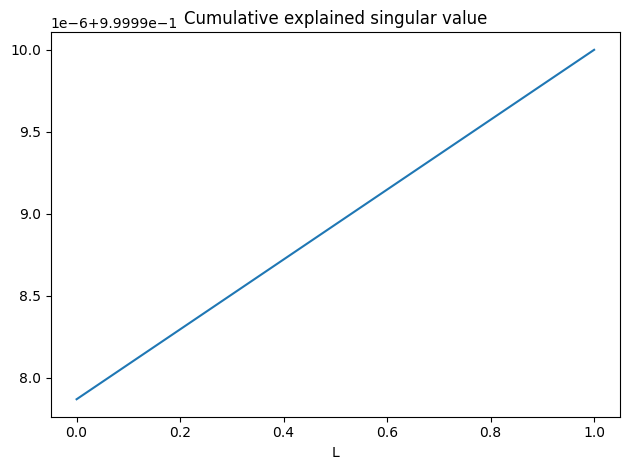

In [ ]:
plt.figure()
plt.plot(np.cumsum(s) / s.sum())
plt.xlabel('L')
plt.title('Cumulative explained singular value')
plt.tight_layout()
plt.show()

### Truncated SVD in Sklearn

In the Sklearn package, truncated SVD will perform like **linear  PCA**, a dimensionality reduction method that reduces the dataset's size by mapping it to a smaller space, which is called "projection." Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In the following image, we can see that the red dots represent the blue dot's projections, and the projections are changed when the line rotates. Both PCA and Truncated SVD in Sklearn will automatically find the "best line" to achieve dimensionality reduction.


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0IT0EN/images/PCA%20Projection.gif" width="600" alt="pca">

<font color=gray>*Image resource* :</font> <a href="https://gist.github.com/anonymous/7d888663c6ec679ea65428715b99bfdd">**GitHub**</a>


We will explore the relationship between PCA and SVD later on.

Some important parameters in `sklearn.decomposition.TruncatedSVD` that are worth noting:

- `n_components`: int, default=2; Desired dimensionality of output data. If algorithm=’arpack’, must be strictly less than the number of features. If algorithm=’randomized’, must be less than or equal to the number of features. The default value is useful for visualisation.

- `algorithm`: {‘arpack’, ‘randomized’}, default=’randomized’; SVD solver to use. Either “arpack” for the ARPACK wrapper in SciPy (scipy.sparse.linalg.svds), or “randomized” for the randomized algorithm due to [Halko (2009)](https://arxiv.org/abs/0909.4061?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0M2GEN69-2022-01-01).

- `n_iter`: int, default=5; Number of iterations for randomized SVD solver. Not used by ARPACK. The default is larger than the default in [randomized_svd](https://scikit-learn.org/stable/modules/generated/sklearn.utils.extmath.randomized_svd.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0M2GEN69-2022-01-01#sklearn.utils.extmath.randomized_svd) to handle sparse matrices that may have large slowly decaying spectrum.

_Read more in the scikit-learn documentation of [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0M2GEN69-2022-01-01)._

First we create a ```TruncatedSVD``` object setting ```n_components=1``` this is analogous to ```L=1``` :


In [ ]:
svd_ = TruncatedSVD(n_components=1, random_state=42)

```fit_transform``` behaves like the projections onto the principle components


In [ ]:
Z = svd_.fit_transform(X)

Z

array([[2.23606798],
       [4.47213595],
       [8.94436135]])

With `inverse_transform`, we can find the approximation of the original $X$:


In [ ]:
Xhat = svd_.inverse_transform(Z)
Matrix(np.round(Xhat))

⎡1.0  2.0⎤
⎢        ⎥
⎢2.0  4.0⎥
⎢        ⎥
⎣4.0  8.0⎦

## **Background Model using SVD**

In this section you will use SVD for developing a Background Model.

Background subtraction is a widely used approach to detect moving objects in a sequence of frames from static cameras. The base in this approach is detecting moving objects from the differences between the current frame and reference frame, which is often called 'Background Image' or 'Background Model'.

The function ```get_data_Matrix```  will create a Design  matrix ```X``` where each row corresponds to a flattened image of a sidewalk with pedestrians recorded by a camera.

```Length``` and ```Width``` are the rectangular dimensions of the image. We will use SVD to remove the pedestrians:


In [ ]:
X, Length, Width = get_data_Matrix(mypath="peds")

There are 170 images in the dataset and each is $152\times 232$ (35264 pixels).


In [ ]:
X.shape, Length, Width

We can plot five random images from the matrix:


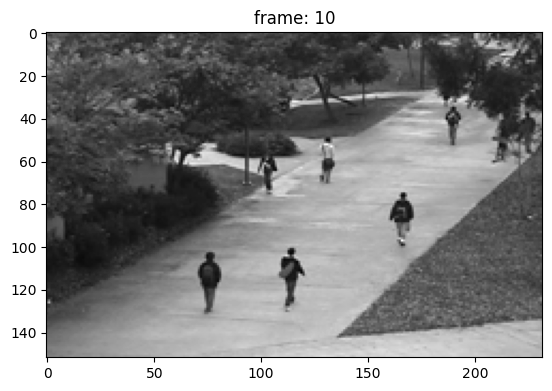

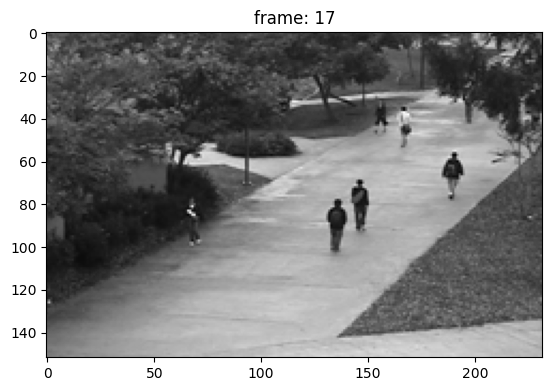

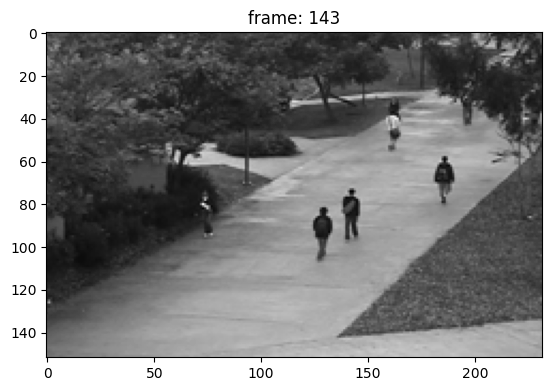

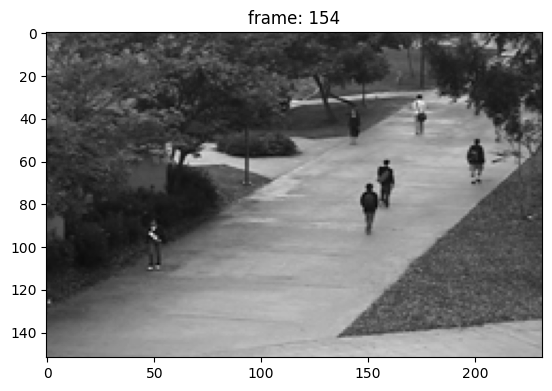

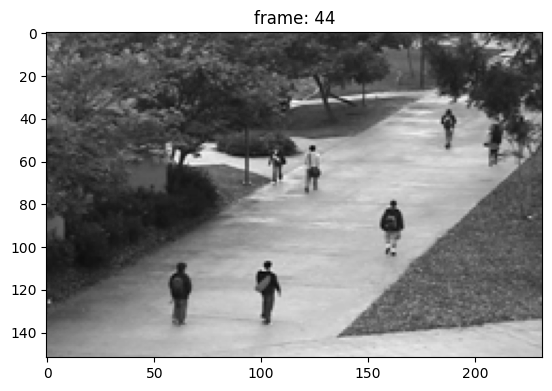

In [ ]:
for i in range(5):
    frame=randint(0, X.shape[0]-1)
    plt.imshow(X[randint(0, X.shape[0]-1),:].reshape(Length,Width),cmap="gray")
    plt.title("frame: "+str(frame))
    plt.show()

We perform SVD on the images:


In [ ]:
U, s, VT = svd(X, full_matrices=False)
S = np.diag(s)

We can reconstruct the image using Truncated SVD with ```L=1``` and assign the result to to ```Xhat```:


In [ ]:
L = 1
Xhat = U[:, :L]@S[0:L, 0:L]@VT[:L, :]

If we plot the first image, we will see the pedestrians are gone:


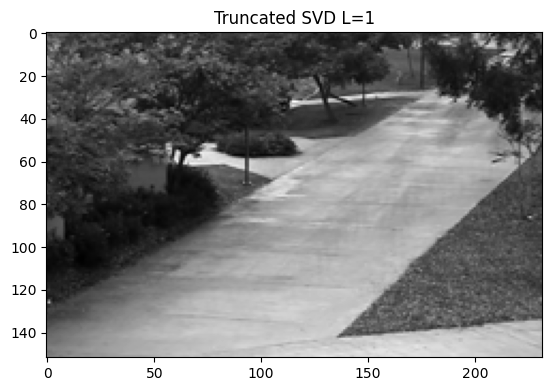

In [ ]:
plt.imshow(Xhat[0,:].reshape(Length,Width),cmap="gray")
plt.title('Truncated SVD L=1')
plt.show()

---


## **Exercises**


### Exercise 1

Reshape the 5 random rows of ```Xhat``` and plot them as images.


In [ ]:
# TODO

<details>
    <summary>Click here for Solution</summary>

```python
for i in range(5):
    frame = randint(0, X.shape[0] - 1)
    plt.imshow(Xhat[randint(0, X.shape[0] - 1), :].reshape(Length, Width), cmap="gray")
    plt.title("frame: " + str(frame))
    plt.show()
```

</details>


From the exercise above that the rows of the matrix ```Xhat``` are all similar . The ```L``` determines the reconstruction properties.


### Exercise 2

Plot the Cumulative explained variance against the number of singular values $L$.


In [ ]:
# TODO

<details>
    <summary>Click here for Solution</summary>

```python
plt.plot(np.cumsum(s) / s.sum())
plt.xlabel("L")
plt.title("Cumulative explained singular value")
plt.show()
```

</details>


### Exercise 3

Perform Truncated SVD with ```L=10``` and plot 5 random rows of Xhat.


In [ ]:
# TODO

<details>
    <summary>Click here for Solution</summary>

```python
L = 10
Xhat = U[:, :L]@S[0:L, 0:L]@VT[:L, :]
for i in range(5):
    frame = randint(0, X.shape[0] - 1)
    plt.imshow(Xhat[randint(0, X.shape[0] - 1), :].reshape(Length, Width), cmap="gray")
    plt.title("frame: " + str(frame))
    plt.show()
```
    
</details>


### Exercise 4

Apply   ```get_data_Matrix``` with ```mypath="boats"```, plot 5 random boat images. Then perform Truncated SVD using the function ```svd``` with  L=1 and plot the first row of ```Xhat``` as an image.


In [ ]:
# TODO

<details>
    <summary>Click here for Solution</summary>

```python
X,Length,Width = get_data_Matrix (mypath="boats")

for i in range(5):
    frame = randint(0, X.shape[0] - 1)
    plt.imshow(X[randint(0, X.shape[0] - 1), :].reshape(Length, Width), cmap="gray")
    plt.title("frame: " + str(frame))
    plt.show()
    
U, s, VT = svd(X, full_matrices=False)
L = 1
Xhat = U[:,:L]@S[0:L,0:L]@VT[:L,:]

plt.imshow(Xhat[0, :].reshape(Length, Width), cmap="gray")
plt.title("Truncated SVD L=1")

plt.show()
```

</details>


### Exercise 5

Apply   ```get_data_Matrix``` with ```mypath="traffic"```, plot 5 random images. Then perform Truncated SVD  using `TruncatedSVD` with ```n_components=1``` and plot the first row of ```Xhat``` as an image.


In [ ]:
# TODO

<details>
    <summary>Click here for Solution</summary>

```python
X,Length,Width = get_data_Matrix (mypath="traffic")

for i in range(5):
    frame = randint(0, X.shape[0] - 1)
    plt.imshow(X[randint(0, X.shape[0] - 1), :].reshape(Length, Width), cmap="gray")
    plt.title("frame: " + str(frame))
    plt.show()
    
svd_ = TruncatedSVD(n_components=1, n_iter=7, random_state=42)
score = svd_.fit_transform(X)
Xhat = svd_.inverse_transform(score)
plt.imshow(Xhat[0, :].reshape(Length,Width), cmap="gray")
plt.imshow(Xhat[0, :].reshape(Length,Width), cmap="gray")
plt.title("Truncated SVD L=1")

plt.show()

```

</details>


---


##  **SVD from Scratch (optional)**

There are several ways to derive SVD, let's do one that is simple to code and related to PCA. We have the SVD factorization:
$$\mathbf{X}= \mathbf {US V^{T}}$$


In [ ]:
X = np.array([[1, 2], [2, 4], [4, 8]])

Matrix(X)

⎡1  2⎤
⎢    ⎥
⎢2  4⎥
⎢    ⎥
⎣4  8⎦

In SVD, the matrix $D \times D$ is a symmetric matrix, and  is almost the same matrix used in PCA if we can scale the covariance matrix by $N$ and obtain the eigenvalues and eigenvectors (eigenvectors have unit norm, so multiplying constant will not affect them):
$$\mathbf{C'}=\mathbf{X}^T \mathbf{X}=\mathbf{V}\mathbf{\Lambda}\mathbf{V}^{T}$$

The $\mathbf{V}$ is the same as the right singular vectors, in Python we can evaluate ```V``` as follows:


In [ ]:
C = X.T@X
eigen_vectors1 , V = eig(C)

Matrix(V)

⎡-0.894427190999916  -0.447213595499958⎤
⎢                                      ⎥
⎣0.447213595499958   -0.894427190999916⎦

We can also perform the same decomposition with the Gram matrix:
$$G=\mathbf{X} \mathbf{X}^T= \mathbf{U \Lambda U^{T}}$$

Where $\mathbf{U}$ are the the right singular vectors:


In [ ]:
G = X@X.T
eigen_vectors2 , U = eig(G)

Matrix(U)

⎡-0.975900072948533  0.218217890235992  0.342661392260052 ⎤
⎢                                                         ⎥
⎢0.0975900072948533  0.436435780471985  -0.871744415370347⎥
⎢                                                         ⎥
⎣0.195180014589707   0.87287156094397   0.350206859620161 ⎦

There are several way to obtains the singular values as we know  $\mathbf{X}= \mathbf {USV^{T}}$. With some algebra we know that $\mathbf{S}=\mathbf{U^TXV}$


In [ ]:
S = np.round((U.T@X@V))

Matrix(S)

⎡0    0  ⎤
⎢        ⎥
⎢0  -10.0⎥
⎢        ⎥
⎣0    0  ⎦

Singular values are not in descending order, and the shape difference is because this is not the economy-size decomposition.
Now that we have all the components, we can reconstruct the matrix:


In [ ]:
X_ = np.round(U@S@V.T)

Matrix(X_)

⎡1.0  2.0⎤
⎢        ⎥
⎢2.0  4.0⎥
⎢        ⎥
⎣4.0  8.0⎦

---


## **Relationship between SVD and PCA (optional)**

In the section above we derived SVD. Let's use this to better understand how SVD and PCA are almost the same. Let's use the following dateset:


In [ ]:
N = 200
u = np.array([[1.0, 1.0], [0.10, -0.10]]) / (2) ** (0.5)
X_ = np.dot(4 * np.random.randn(N, 2), u) + 10
X = X_ - X_.mean(axis=0)

Let's compare SVD to sklearn's PCA  setting ```n_components=1```


In [ ]:
U, s, VT = svd(X, full_matrices=False)

In [ ]:
pca = PCA(n_components=1)
projection = pca.fit_transform(X)
X_sklearn = pca.inverse_transform(projection)

As $\mathbf{V}$ are the principal components, the projections on the principal components can be found by multiplying $\mathbf{X}$ and $\mathbf{V}$, if we want the projection on the first principal components, we can take the row of $\mathbf{V}$ with the largest Singular-Value Value and compare it to scikit-learn's. We see the result is identical:


In [ ]:
projection_ = X@VT[0, :]
print("error SVD vs scikit-learn's PCA", (projection_ - projection).sum())

error SVD vs scikit-learn's PCA -1.446096575818956e-10


We can also find the projections using  $\mathbf{XV}= \mathbf {US}$. Here we find the  projection on the first principal component  to compare to scikit-learn's


In [ ]:
projection_ = U@np.diag(s)[:, 0]
print("error SVD vs scikit-learn's PCA", (projection_ - projection).sum())

error SVD vs scikit-learn's PCA -1.4097167877480388e-10


The inverse transform on the first  principal component is simply the low rank approximation:


In [ ]:
L = 1
Xhat = U[:, :L]@np.diag(s[0:L])@VT[:L, :] # resconstruct X
print ("error SVD vs scikit-learn's PCA", ((Xhat - X_sklearn) ** 2).sum())

error SVD vs scikit-learn's PCA 1.287212111598392e-27


The relationship between the explained variance and singular  values are given by  $\lambda_i = s_i^2/(N-1)$ we can verify the for the first singular value:


In [ ]:
s[0] ** 2 / (200 - 1)

In [ ]:
pca.explained_variance_

array([13.69808238])

---


# Congratulations! - You have completed the lab


## Authors

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01"> Joseph Santarcangelo</a> has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

<a href="https://www.linkedin.com/in/sheng-kai-chen?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsINDGPXX09KMEN1135-2022-01-01"> Sheng-Kai Chen</a> is a graduate student at the University of Toronto, concentrating on Information Systems & Design. Having several experiences analyzing data for retail stores and designing small software for small businesses, Sheng-Kai was inspired to shift toward answering new challenges with machine learning.


### Other Contributors

[Roxanne Li](https://www.linkedin.com/in/roxanne-li/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0M2GEN69-2022-01-01) is a Data Science intern at IBM Skills Network, entering level-5 study in the Mathematics & Statistics undergraduate Coop program at McMaster University.


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By  | Change Description             |
| ----------------- | ------- | ----------- | ------------------------------ |
| 2022-03-25        | 0.1     | Joseph S.   | Updated all content            |
| 2022-04-26        | 0.1     | Svitlana K. | Corrected minor grammar errors |
| 2022-05-26        | 0.1     | Roxanne Li  | Review and edit content    |
| 2022-06-02        | 0.2     | Steve H.    | QA pass     |
| 2022-10-27        | 0.3     | Shengkai C. | Updated partial content     |


Copyright © 2022 IBM Corporation. All rights reserved.
